In [1]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=96270cda296f1a92967db7a54e73802ccf4f31d09a61ac2fa108f54f0109cbd0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [2]:
import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.cuda.amp import autocast, GradScaler

# Load the CSV files
training_df = pd.read_csv('/kaggle/input/training-csv-01/Training_set.csv')
training_df.head()

# Checking for missing values in the training dataset
missing_values = training_df.isnull().sum()
print(missing_values)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


filename    0
label       0
dtype: int64


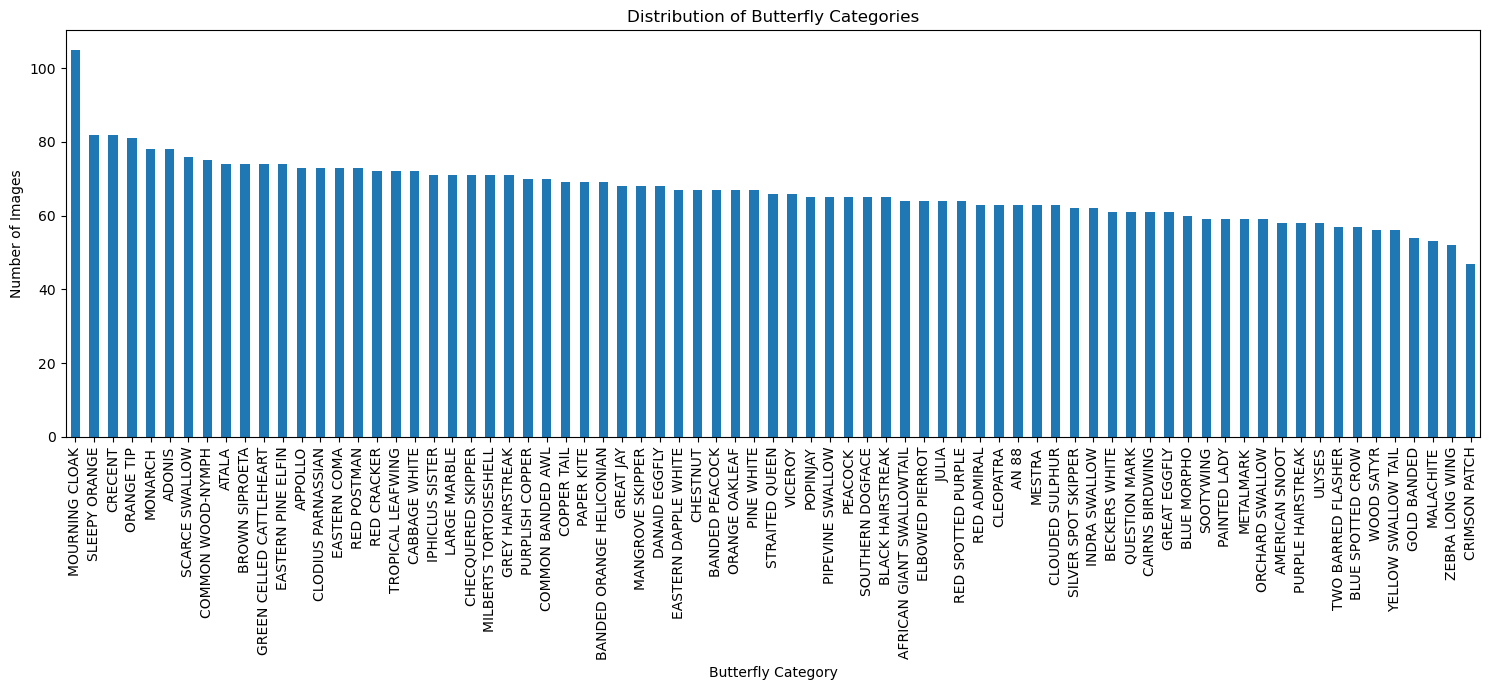

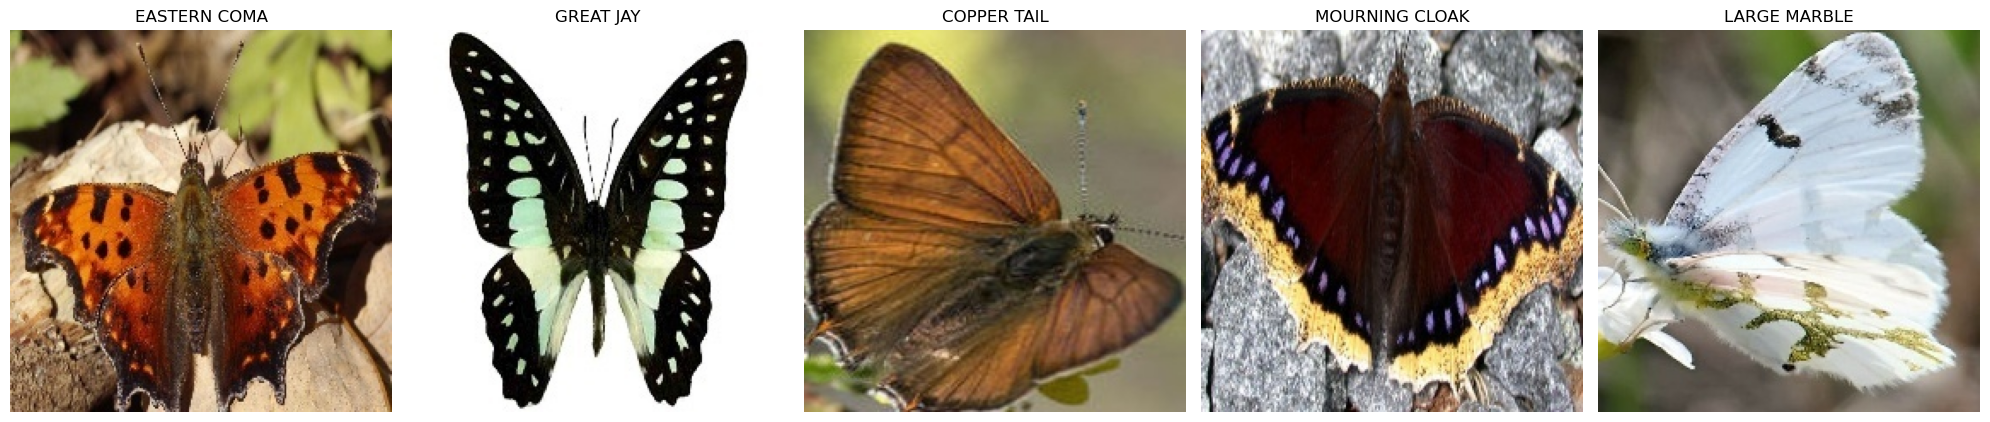

In [3]:
# Plotting the distribution of the butterfly categories
plt.figure(figsize=(15, 7))
training_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Selecting a random sample of images
sample_images = random.sample(list(training_df['filename']), 5)

# Plotting the sample images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, img_name in zip(axes, sample_images):
    img_path = os.path.join('/kaggle/input/train-f-01/train', img_name)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(training_df[training_df['filename'] == img_name]['label'].values[0])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [4]:
# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Image Processing
IMG_WIDTH = 224
IMG_HEIGHT = 224

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


Using device: cuda:0


In [5]:
train_image_paths = [os.path.join('/kaggle/input/train-f-01/train', fname) for fname in training_df['filename']]
labels = training_df['label'].values

# Convert class labels to integers
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# Split the data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels
)

# Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(IMG_WIDTH, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train_split, y_train_split, transform=train_transforms)
val_dataset = CustomDataset(X_val_split, y_val_split, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)


In [6]:
# Define the model
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=75):
        super(CustomEfficientNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b7')
        num_features = self.base_model._fc.in_features
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.fc(x)
        return x

model = CustomEfficientNet().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)  # Added L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Helper function to compute accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')

early_stopping = EarlyStopping(patience=7, verbose=True)
scaler = GradScaler()
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
accumulation_steps = 4  # Điều chỉnh giá trị này tùy ý


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 274MB/s]  


Loaded pretrained weights for efficientnet-b7


In [7]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_train_acc = 0.0
    optimizer.zero_grad()
    
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        running_loss += loss.item()
        running_train_acc += accuracy(outputs, labels)
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(running_train_acc / len(train_loader))
    
    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            running_val_acc += accuracy(outputs, labels)
    
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(running_val_acc / len(val_loader))

    scheduler.step(running_val_loss / len(val_loader))  # Adjust learning rate based on validation loss

    print(f"Epoch: {epoch+1} | train_loss: {train_losses[-1]:.4f} | train_acc: {train_accuracies[-1]:.4f} | val_loss: {val_losses[-1]:.4f} | val_acc: {val_accuracies[-1]:.4f}")

    early_stopping(running_val_loss / len(val_loader), model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model
model.load_state_dict(torch.load('checkpoint.pt'))

# Save the model
torch.save(model.state_dict(), 'butterfly_classification_model.pt')


Epoch 1 Validation: 100%|██████████| 63/63 [00:07<00:00,  7.90it/s]


Epoch: 1 | train_loss: 3.8627 | train_acc: 0.1340 | val_loss: 2.8849 | val_acc: 0.5159
Validation loss decreased (2.884917 --> 2.884917).  Saving model ...


Epoch 2 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.36it/s]


Epoch: 2 | train_loss: 2.2443 | train_acc: 0.5117 | val_loss: 1.3139 | val_acc: 0.7857
Validation loss decreased (1.313884 --> 1.313884).  Saving model ...


Epoch 3 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.37it/s]


Epoch: 3 | train_loss: 1.2823 | train_acc: 0.7188 | val_loss: 0.6667 | val_acc: 0.8492
Validation loss decreased (0.666655 --> 0.666655).  Saving model ...


Epoch 4 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.35it/s]


Epoch: 4 | train_loss: 0.8872 | train_acc: 0.7943 | val_loss: 0.4870 | val_acc: 0.8958
Validation loss decreased (0.487029 --> 0.487029).  Saving model ...


Epoch 5 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.34it/s]


Epoch: 5 | train_loss: 0.6952 | train_acc: 0.8335 | val_loss: 0.4683 | val_acc: 0.8849
Validation loss decreased (0.468256 --> 0.468256).  Saving model ...


Epoch 6 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.40it/s]


Epoch: 6 | train_loss: 0.5826 | train_acc: 0.8472 | val_loss: 0.4396 | val_acc: 0.8889
Validation loss decreased (0.439558 --> 0.439558).  Saving model ...


Epoch 7 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.39it/s]


Epoch: 7 | train_loss: 0.5665 | train_acc: 0.8518 | val_loss: 0.4248 | val_acc: 0.8800
Validation loss decreased (0.424832 --> 0.424832).  Saving model ...


Epoch 8 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.36it/s]


Epoch: 8 | train_loss: 0.4852 | train_acc: 0.8750 | val_loss: 0.3748 | val_acc: 0.9048
Validation loss decreased (0.374822 --> 0.374822).  Saving model ...


Epoch 9 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.28it/s]


Epoch: 9 | train_loss: 0.4226 | train_acc: 0.8935 | val_loss: 0.3509 | val_acc: 0.9137
Validation loss decreased (0.350881 --> 0.350881).  Saving model ...


Epoch 10 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.39it/s]


Epoch: 10 | train_loss: 0.4182 | train_acc: 0.8895 | val_loss: 0.4120 | val_acc: 0.8988


Epoch 11 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.38it/s]


Epoch: 11 | train_loss: 0.4129 | train_acc: 0.8938 | val_loss: 0.3740 | val_acc: 0.9058


Epoch 12 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.35it/s]


Epoch: 12 | train_loss: 0.3757 | train_acc: 0.9010 | val_loss: 0.3891 | val_acc: 0.9117


Epoch 13 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.36it/s]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 13 | train_loss: 0.3489 | train_acc: 0.9103 | val_loss: 0.4184 | val_acc: 0.8889


Epoch 14 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.37it/s]


Epoch: 14 | train_loss: 0.2883 | train_acc: 0.9220 | val_loss: 0.2882 | val_acc: 0.9315
Validation loss decreased (0.288239 --> 0.288239).  Saving model ...


Epoch 15 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.34it/s]


Epoch: 15 | train_loss: 0.2218 | train_acc: 0.9410 | val_loss: 0.2795 | val_acc: 0.9306
Validation loss decreased (0.279547 --> 0.279547).  Saving model ...


Epoch 16 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.33it/s]


Epoch: 16 | train_loss: 0.1928 | train_acc: 0.9528 | val_loss: 0.2786 | val_acc: 0.9306
Validation loss decreased (0.278559 --> 0.278559).  Saving model ...


Epoch 17 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.33it/s]


Epoch: 17 | train_loss: 0.1755 | train_acc: 0.9565 | val_loss: 0.2718 | val_acc: 0.9375
Validation loss decreased (0.271816 --> 0.271816).  Saving model ...


Epoch 18 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.34it/s]


Epoch: 18 | train_loss: 0.1670 | train_acc: 0.9557 | val_loss: 0.2648 | val_acc: 0.9405
Validation loss decreased (0.264766 --> 0.264766).  Saving model ...


Epoch 19 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.31it/s]


Epoch: 19 | train_loss: 0.1741 | train_acc: 0.9550 | val_loss: 0.2564 | val_acc: 0.9444
Validation loss decreased (0.256436 --> 0.256436).  Saving model ...


Epoch 20 Validation: 100%|██████████| 63/63 [00:08<00:00,  7.54it/s]


Epoch: 20 | train_loss: 0.1539 | train_acc: 0.9582 | val_loss: 0.2602 | val_acc: 0.9415


Epoch 21 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.34it/s]


Epoch: 21 | train_loss: 0.1426 | train_acc: 0.9655 | val_loss: 0.2659 | val_acc: 0.9385


Epoch 22 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.30it/s]


Epoch: 22 | train_loss: 0.1371 | train_acc: 0.9678 | val_loss: 0.2701 | val_acc: 0.9395


Epoch 23 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.36it/s]


Epoch: 23 | train_loss: 0.1340 | train_acc: 0.9650 | val_loss: 0.2563 | val_acc: 0.9425
Validation loss decreased (0.256256 --> 0.256256).  Saving model ...


Epoch 24 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.38it/s]


Epoch: 24 | train_loss: 0.1359 | train_acc: 0.9647 | val_loss: 0.2712 | val_acc: 0.9385


Epoch 25 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.36it/s]


Epoch: 25 | train_loss: 0.1279 | train_acc: 0.9672 | val_loss: 0.2635 | val_acc: 0.9425


Epoch 26 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.33it/s]


Epoch: 26 | train_loss: 0.1374 | train_acc: 0.9660 | val_loss: 0.2672 | val_acc: 0.9405


Epoch 27 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.32it/s]


Epoch 00027: reducing learning rate of group 0 to 5.0000e-06.
Epoch: 27 | train_loss: 0.1154 | train_acc: 0.9697 | val_loss: 0.2685 | val_acc: 0.9444


Epoch 28 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.33it/s]


Epoch: 28 | train_loss: 0.0965 | train_acc: 0.9753 | val_loss: 0.2686 | val_acc: 0.9435


Epoch 29 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.35it/s]


Epoch: 29 | train_loss: 0.1121 | train_acc: 0.9693 | val_loss: 0.2692 | val_acc: 0.9415


Epoch 30 Validation: 100%|██████████| 63/63 [00:07<00:00,  8.33it/s]


Epoch: 30 | train_loss: 0.1204 | train_acc: 0.9720 | val_loss: 0.2685 | val_acc: 0.9435
Early stopping


filename    0
label       0
dtype: int64


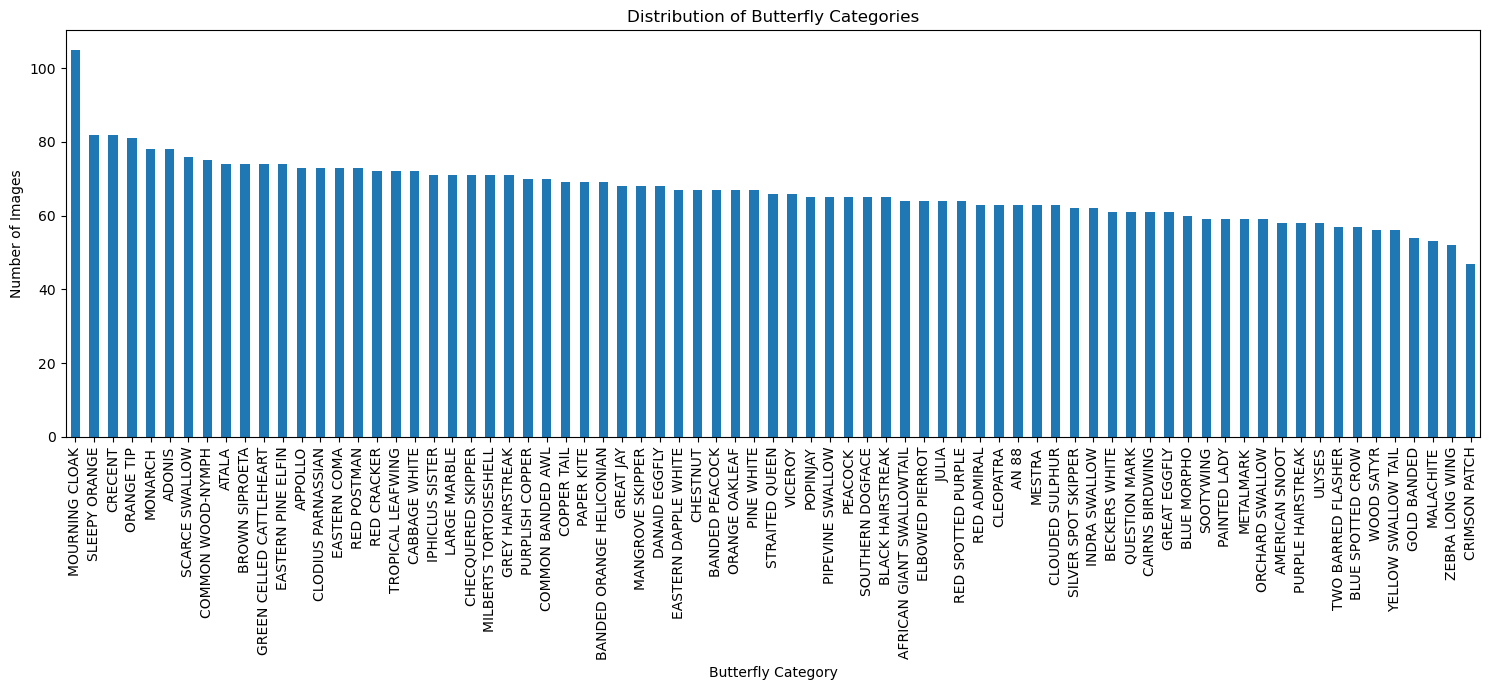

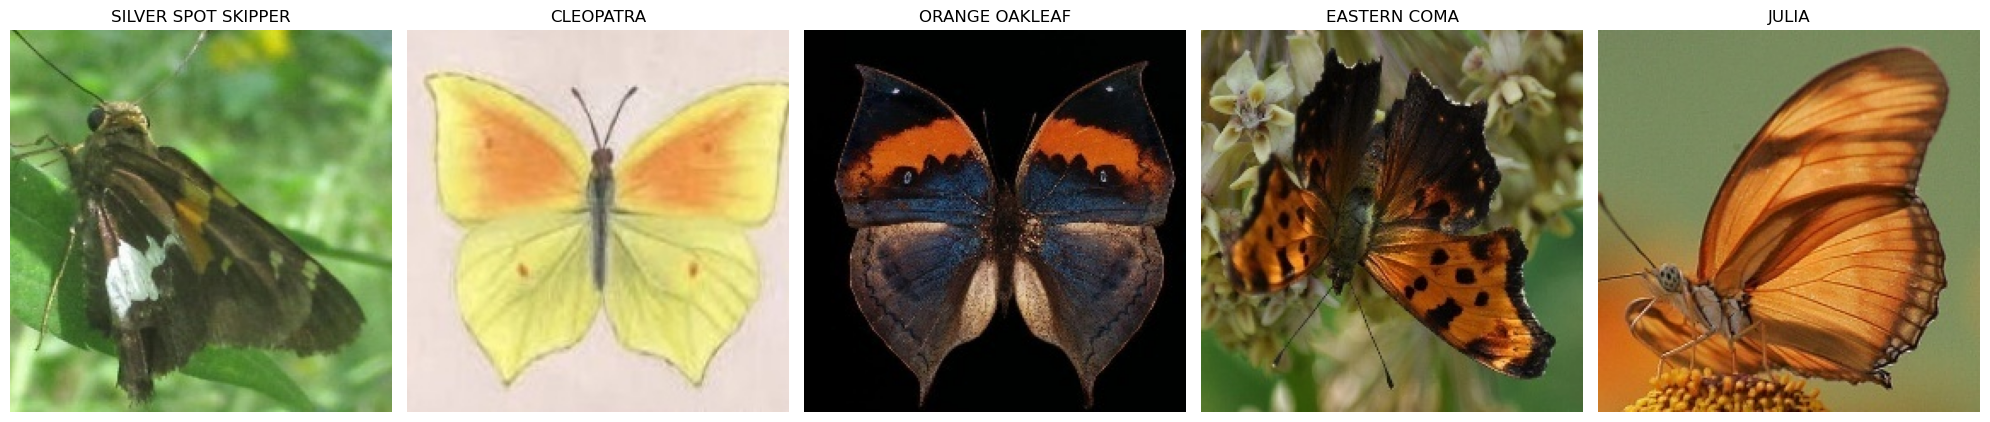

Using device: cuda:0
Loaded pretrained weights for efficientnet-b4


Epoch 1 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.63it/s]


Epoch: 1 | train_loss: 3.8926 | train_acc: 0.1252 | val_loss: 2.8218 | val_acc: 0.5069
Validation loss decreased (2.821845 --> 2.821845).  Saving model ...


Epoch 2 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.62it/s]


Epoch: 2 | train_loss: 2.3818 | train_acc: 0.4830 | val_loss: 1.4118 | val_acc: 0.7758
Validation loss decreased (1.411820 --> 1.411820).  Saving model ...


Epoch 3 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.66it/s]


Epoch: 3 | train_loss: 1.4188 | train_acc: 0.6915 | val_loss: 0.7702 | val_acc: 0.8452
Validation loss decreased (0.770178 --> 0.770178).  Saving model ...


Epoch 4 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.70it/s]


Epoch: 4 | train_loss: 0.9498 | train_acc: 0.7845 | val_loss: 0.6231 | val_acc: 0.8552
Validation loss decreased (0.623051 --> 0.623051).  Saving model ...


Epoch 5 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.86it/s]


Epoch: 5 | train_loss: 0.7443 | train_acc: 0.8200 | val_loss: 0.5003 | val_acc: 0.8681
Validation loss decreased (0.500268 --> 0.500268).  Saving model ...


Epoch 6 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.72it/s]


Epoch: 6 | train_loss: 0.6308 | train_acc: 0.8430 | val_loss: 0.4188 | val_acc: 0.8948
Validation loss decreased (0.418830 --> 0.418830).  Saving model ...


Epoch 7 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.79it/s]


Epoch: 7 | train_loss: 0.5489 | train_acc: 0.8583 | val_loss: 0.3939 | val_acc: 0.8849
Validation loss decreased (0.393941 --> 0.393941).  Saving model ...


Epoch 8 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.70it/s]


Epoch: 8 | train_loss: 0.4820 | train_acc: 0.8748 | val_loss: 0.3812 | val_acc: 0.8909
Validation loss decreased (0.381216 --> 0.381216).  Saving model ...


Epoch 9 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.15it/s]


Epoch: 9 | train_loss: 0.4467 | train_acc: 0.8852 | val_loss: 0.3908 | val_acc: 0.8978


Epoch 10 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.60it/s]


Epoch: 10 | train_loss: 0.4221 | train_acc: 0.8898 | val_loss: 0.3564 | val_acc: 0.9137
Validation loss decreased (0.356439 --> 0.356439).  Saving model ...


Epoch 11 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.58it/s]


Epoch: 11 | train_loss: 0.3727 | train_acc: 0.9035 | val_loss: 0.3186 | val_acc: 0.9236
Validation loss decreased (0.318577 --> 0.318577).  Saving model ...


Epoch 12 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.54it/s]


Epoch: 12 | train_loss: 0.3378 | train_acc: 0.9105 | val_loss: 0.3336 | val_acc: 0.9236


Epoch 13 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.66it/s]


Epoch: 13 | train_loss: 0.3337 | train_acc: 0.9082 | val_loss: 0.3345 | val_acc: 0.9157


Epoch 14 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.23it/s]


Epoch: 14 | train_loss: 0.3093 | train_acc: 0.9158 | val_loss: 0.3675 | val_acc: 0.9167


Epoch 15 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.21it/s]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-05.
Epoch: 15 | train_loss: 0.2759 | train_acc: 0.9293 | val_loss: 0.3301 | val_acc: 0.9196


Epoch 16 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.81it/s]


Epoch: 16 | train_loss: 0.2346 | train_acc: 0.9317 | val_loss: 0.2821 | val_acc: 0.9385
Validation loss decreased (0.282105 --> 0.282105).  Saving model ...


Epoch 17 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.85it/s]


Epoch: 17 | train_loss: 0.1939 | train_acc: 0.9460 | val_loss: 0.2726 | val_acc: 0.9375
Validation loss decreased (0.272608 --> 0.272608).  Saving model ...


Epoch 18 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.61it/s]


Epoch: 18 | train_loss: 0.1886 | train_acc: 0.9490 | val_loss: 0.2697 | val_acc: 0.9385
Validation loss decreased (0.269707 --> 0.269707).  Saving model ...


Epoch 19 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.39it/s]


Epoch: 19 | train_loss: 0.1742 | train_acc: 0.9545 | val_loss: 0.2677 | val_acc: 0.9355
Validation loss decreased (0.267695 --> 0.267695).  Saving model ...


Epoch 20 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.47it/s]


Epoch: 20 | train_loss: 0.1666 | train_acc: 0.9560 | val_loss: 0.2674 | val_acc: 0.9395
Validation loss decreased (0.267407 --> 0.267407).  Saving model ...


Epoch 21 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.12it/s]


Epoch: 21 | train_loss: 0.1539 | train_acc: 0.9600 | val_loss: 0.2683 | val_acc: 0.9395


Epoch 22 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.73it/s]


Epoch: 22 | train_loss: 0.1495 | train_acc: 0.9585 | val_loss: 0.2679 | val_acc: 0.9375


Epoch 23 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.50it/s]


Epoch: 23 | train_loss: 0.1328 | train_acc: 0.9647 | val_loss: 0.2670 | val_acc: 0.9395
Validation loss decreased (0.266958 --> 0.266958).  Saving model ...


Epoch 24 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.25it/s]


Epoch: 24 | train_loss: 0.1429 | train_acc: 0.9592 | val_loss: 0.2711 | val_acc: 0.9375


Epoch 25 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.58it/s]


Epoch: 25 | train_loss: 0.1178 | train_acc: 0.9710 | val_loss: 0.2710 | val_acc: 0.9415


Epoch 26 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.90it/s]


Epoch: 26 | train_loss: 0.1243 | train_acc: 0.9690 | val_loss: 0.2701 | val_acc: 0.9425


Epoch 27 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.79it/s]


Epoch: 27 | train_loss: 0.1261 | train_acc: 0.9663 | val_loss: 0.2631 | val_acc: 0.9415
Validation loss decreased (0.263111 --> 0.263111).  Saving model ...


Epoch 28 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.59it/s]


Epoch: 28 | train_loss: 0.1243 | train_acc: 0.9665 | val_loss: 0.2700 | val_acc: 0.9425


Epoch 29 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.13it/s]


Epoch: 29 | train_loss: 0.1170 | train_acc: 0.9710 | val_loss: 0.2774 | val_acc: 0.9375


Epoch 30 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.29it/s]


Epoch: 30 | train_loss: 0.1070 | train_acc: 0.9718 | val_loss: 0.2768 | val_acc: 0.9405


Epoch 31 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.49it/s]


Epoch 00031: reducing learning rate of group 0 to 5.0000e-06.
Epoch: 31 | train_loss: 0.1161 | train_acc: 0.9685 | val_loss: 0.2803 | val_acc: 0.9425


Epoch 32 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.68it/s]


Epoch: 32 | train_loss: 0.1071 | train_acc: 0.9728 | val_loss: 0.2801 | val_acc: 0.9405


Epoch 33 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.53it/s]


Epoch: 33 | train_loss: 0.1118 | train_acc: 0.9718 | val_loss: 0.2805 | val_acc: 0.9405


Epoch 34 Validation: 100%|██████████| 63/63 [00:03<00:00, 17.77it/s]


Epoch: 34 | train_loss: 0.1065 | train_acc: 0.9707 | val_loss: 0.2772 | val_acc: 0.9425
Early stopping


In [6]:
import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.cuda.amp import autocast, GradScaler

# Load the CSV files
training_df = pd.read_csv('/kaggle/input/training-csv-01/Training_set.csv')
training_df.head()

# Checking for missing values in the training dataset
missing_values = training_df.isnull().sum()
print(missing_values)

# Plotting the distribution of the butterfly categories
plt.figure(figsize=(15, 7))
training_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Butterfly Categories')
plt.xlabel('Butterfly Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Selecting a random sample of images
sample_images = random.sample(list(training_df['filename']), 5)

# Plotting the sample images
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for ax, img_name in zip(axes, sample_images):
    img_path = os.path.join('/kaggle/input/train-f-01/train', img_name)
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(training_df[training_df['filename'] == img_name]['label'].values[0])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Image Processing
IMG_WIDTH = 224
IMG_HEIGHT = 224

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_image_paths = [os.path.join('/kaggle/input/train-f-01/train', fname) for fname in training_df['filename']]
labels = training_df['label'].values

# Convert class labels to integers
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# Split the data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels
)

# Data Augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(IMG_WIDTH, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train_split, y_train_split, transform=train_transforms)
val_dataset = CustomDataset(X_val_split, y_val_split, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Define the model
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=75):
        super(CustomEfficientNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b4')
        num_features = self.base_model._fc.in_features
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.fc(x)
        return x

model = CustomEfficientNet().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)  # Added L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Helper function to compute accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Early stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')

early_stopping = EarlyStopping(patience=7, verbose=True)
scaler = GradScaler()
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
accumulation_steps = 4  # Điều chỉnh giá trị này tùy ý

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_train_acc = 0.0
    optimizer.zero_grad()
    
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        running_loss += loss.item()
        running_train_acc += accuracy(outputs, labels)
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(running_train_acc / len(train_loader))
    
    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            running_val_acc += accuracy(outputs, labels)
    
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(running_val_acc / len(val_loader))

    scheduler.step(running_val_loss / len(val_loader))  # Adjust learning rate based on validation loss

    print(f"Epoch: {epoch+1} | train_loss: {train_losses[-1]:.4f} | train_acc: {train_accuracies[-1]:.4f} | val_loss: {val_losses[-1]:.4f} | val_acc: {val_accuracies[-1]:.4f}")

    early_stopping(running_val_loss / len(val_loader), model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model
model.load_state_dict(torch.load('checkpoint.pt'))

# Save the model
torch.save(model.state_dict(), 'butterfly_classification_model.pt')


In [7]:
model.eval()
all_preds = []
all_true = []

# Get predictions on validation set
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating Validation Set"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Calculate metrics
accuracy_val = accuracy_score(all_true, all_preds)
precision_val = precision_score(all_true, all_preds, average='weighted')
recall_val = recall_score(all_true, all_preds, average='weighted')
f1_val = f1_score(all_true, all_preds, average='weighted')

print(f"Validation Accuracy: {accuracy_val:.4f}")
print(f"Validation Precision: {precision_val:.4f}")
print(f"Validation Recall: {recall_val:.4f}")
print(f"Validation F1-Score: {f1_val:.4f}")


Evaluating Validation Set: 100%|██████████| 63/63 [00:05<00:00, 11.37it/s]

Validation Accuracy: 0.9410
Validation Precision: 0.9437
Validation Recall: 0.9410
Validation F1-Score: 0.9410


In [5]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from efficientnet_pytorch import EfficientNet
import matplotlib.image as mpimg

# Assuming test images are located in '/kaggle/input/test-f-01/test' directory
test_dir = '/kaggle/input/test-f-01/test'

# Image processing parameters
IMG_WIDTH = 224
IMG_HEIGHT = 224

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define Dataset class for test data
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB").resize((IMG_WIDTH, IMG_HEIGHT))
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(self.image_paths[idx])  # Return filename as well

# Transformations for test data (similar to validation)
test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create list of test file paths
test_image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]

# Create TestDataset instance
test_dataset = TestDataset(test_image_paths, transform=test_transforms)

# DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Define the model architecture (assuming already trained and loaded)
class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes=75):
        super(CustomEfficientNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b4')
        num_features = self.base_model._fc.in_features
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(num_features, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.fc(x)
        return x

# Load your trained model
model = CustomEfficientNet().to(device)
model.load_state_dict(torch.load('butterfly_classification_model.pt'))

# Function to predict labels for test set
def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, filenames in tqdm(test_loader, desc="Predicting on test set"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = le.inverse_transform(predicted.cpu().numpy())  # Convert labels back to original names
            predictions.extend(zip(filenames, predicted_labels))

    return predictions

# Get predictions
predictions = predict(model, test_loader)

# Create DataFrame for predictions
predictions_df = pd.DataFrame(predictions, columns=['ID', 'label'])

# Save predictions to CSV file
predictions_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


Using device: cuda:0
Loaded pretrained weights for efficientnet-b4


Predicting on test set: 100%|██████████| 94/94 [00:08<00:00, 11.31it/s]

Predictions saved to predictions.csv


# Dependencies

# Calculate metrics
